# Pengerjaan Tugas Deep Learning Week 6 Menggunakan PyTorch

# Tahap Persiapan

## 1. Instalasi Modul yang diperlukan

In [44]:
# !pip install numpy pandas matplotlib scikit-learn torch torchtext
%pip install numpy pandas matplotlib scikit-learn torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


## 2. Mengimpor Library yang Dibutuhkan

In [45]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import json
import re
import string
import time
from copy import deepcopy

## 3. Mendefinisikan Parameter dan Pre-processing Dataset

In [ ]:
# Konstanta dan parameter
NUM_WORDS = 40000
MAXLEN = 30
BATCH_SIZE = 16
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 1
EPOCHS = 25
LEARNING_RATE = 0.0001

# Memeriksa apakah GPU tersedia
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Menggunakan device: {DEVICE}")

# Baca file JSON yang tidak terformat
input_file = "../DeteksiSarkasme.json"
json_data = []

with open(input_file, "r") as file:
    data = file.read()

# Tampilkan cuplikan dari data JSON yang tidak terformat
print("Cuplikan data JSON yang tidak terformat:")
print(data[:500])  # Menampilkan 500 karakter pertama untuk cuplikan

# Tambahkan koma di antara objek JSON
formatted_data = "[" + data.replace("}\n{", "},\n{") + "]"

# Tampilkan cuplikan dari data JSON yang sudah diformat
print("\nCuplikan data JSON yang sudah diformat:")
print(formatted_data[:500])  # Menampilkan 500 karakter pertama untuk cuplikan

# Parse ulang untuk memastikan validitas JSON
try:
    json_data = json.loads(formatted_data)
    print("\nData JSON berhasil diformat.")

except json.JSONDecodeError as e:
    print(f"Terjadi kesalahan saat memformat JSON: {e}")

# Convert to DataFrame
df = pd.DataFrame(json_data)

# Check class distribution
print("Class distribution:")
print(df['is_sarcastic'].value_counts())
print("\nPercentage:")
print(df['is_sarcastic'].value_counts(normalize=True) * 100)

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Pertahankan tanda baca yang berpotensi penting untuk sarkasme
    text = re.sub(r'[^\w\s\'\"!?.,]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Filter stopwords secara selektif (pertahankan kata-kata penting)
    custom_stopwords = set(stopwords.words('english')) - {'not', 'no', 'very', 'too', 'only', 'just'}
    tokens = [word for word in tokens if word not in custom_stopwords]

    return ' '.join(tokens)

# Apply preprocessing to headlines
df['processed_headline'] = df['headline'].apply(preprocess_text)
print("\nProcessed headlines:")
print(df['processed_headline'].head())

# Extract additional words from the website links
df['additional_words'] = df['article_link'].apply(
    lambda x: re.findall(r'\w+', x.split('/')[-1]) if '/' in x else []
).apply(lambda x: [word for word in x if word not in ['html', 'htm'] and len(word) > 1])
df['additional_words'] = df['additional_words'].apply(
    lambda x: x[:-1] + x[-1].split('_')[:-1] if x and len(x[-1].split('_')) > 1 else x
)
df['additional_words'] = df['additional_words'].apply(
    lambda x: x[:-1] if x and len(x[-1]) < 3 else x
)
print(df['additional_words'])

# Combine processed headline and additional words
df['processed_headline'] = ' ' + df['additional_words'].apply(' '.join) + ' ' + df['processed_headline']
print("\nCombined processed headlines:")
print(df['processed_headline'].head())

# Check for null values
print("\nChecking for null values:")
print(df.isnull().sum())

# Drop rows with null values
df.dropna(inplace=True)
print("\nAfter dropping null values:")
print(df.isnull().sum())

# Split data
X = df['processed_headline'].values
y = df['is_sarcastic'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Tokenization and padding for deep learning models
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Pad sequences for uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAXLEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAXLEN, padding='post')

# Mengonversi data ke tensor PyTorch
x_train_tensor = torch.tensor(X_train_pad, dtype=torch.long).to(DEVICE)
x_test_tensor = torch.tensor(X_test_pad, dtype=torch.long).to(DEVICE)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(DEVICE)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).to(DEVICE)

# Mengonversi data ke TensorDataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Membuat DataLoader untuk pelatihan, validasi, dan pengujian
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Menggunakan device: cpu
Cuplikan data JSON yang tidak terformat:
{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5", "headline": "former versace store clerk sues over secret 'black code' for minority shoppers", "is_sarcastic": 0}
{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365", "headline": "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "is_sarcastic": 0}
{"article_link": "https://local.theonion.com/mom-starti

Cuplikan data JSON yang sudah diformat:
[{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5", "headline": "former versace store clerk sues over secret 'black code' for minority shoppers", "is_sarcastic": 0},
{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365", "headline": "the 'roseanne' revival catches up to our thorny poli

## 4. Menyiapkan Fungsi Pelatihan dan Validasi

In [47]:
# Fungsi untuk melatih model
def train_model(model, train_loader, criterion, optimizer, device, epochs, model_name):
    model.train()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    history = {'accuracy': [], 'loss': [], 'val_accuracy': [], 'val_loss': []}
    best_epoch = 0
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.float().to(device).view(-1, 1)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted = (outputs.data > 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
        train_accuracy = correct / total
        train_loss = train_loss / (batch_idx + 1)
        
        # Validasi
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(test_loader):
                inputs, targets = inputs.to(device), targets.float().to(device).view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                predicted = (outputs.data > 0.5).float()
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        
        val_accuracy = val_correct / val_total
        val_loss = val_loss / (batch_idx + 1)
        
        history['accuracy'].append(train_accuracy)
        history['loss'].append(train_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        print(f'Epoch: {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
            
        # Simpan model terbaik berdasarkan loss validasi
        if val_loss < min(history['val_loss'][:-1], default=float('inf')):
            print(f"Checkpoint: Model disimpan sebagai 'model_pytorch_{model_name}.pth' (validation loss terendah = {val_loss:.4f})")
            best_epoch = epoch + 1
            best_val_loss = val_loss
            torch.save(deepcopy(model.state_dict()), f'model_pytorch_{model_name}.pth')
        
        # Pelatihan diakhiri lebih awal jika tidak ada perbaikan dalam 5 epoch terakhir
        if len(history['val_loss']) > 7 and all(x > best_val_loss for x in history['val_loss'][-7:]):
            print("Early stopping: Tidak ada perbaikan dalam 5 epoch terakhir.")
            break
    
    print(f"Pelatihan selesai. Model terbaik pada epoch = {best_epoch}, dengan validation loss = {best_val_loss} disimpan.")
    return history

## 5. Menyiapkan Fungsi Evaluasi

In [48]:
# Fungsi untuk evaluasi model
def evaluate_model(model, test_loader, criterion, device):
    model.to(device)
    model.eval()
    test_loss = 0
    all_preds = []
    all_probs = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data).squeeze(1)
            test_loss += criterion(output, target).item()
            
            pred = (output > 0.5).float()
            all_probs.extend(output.cpu().numpy())
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_loss /= len(test_loader)
    
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    
    # Menghitung ROC curve dan AUC
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    roc_auc = auc(fpr, tpr)
    
    results = {
        'loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred': all_preds,
        'y_pred_prob': all_probs
    }
    
    return results

## 6. Menyiapkan Fungsi Visualisasi

In [49]:
# Fungsi untuk membuat visualisasi hasil
# Fungsi untuk membuat visualisasi training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    best_epoch = history['val_loss'].index(min(history['val_loss']))
    best_val_loss = min(history['val_loss'])

    # Plot Loss, dengan tanda pada titik terbaik
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Valid Loss')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    plt.axhline(y=best_val_loss, color='g', linestyle='--', label='Best Val Loss')
    plt.title(f'{model_name} - Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Valid Accuracy')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    plt.axhline(y=history['val_accuracy'][best_epoch], color='g', linestyle='--', label='Val Accuracy at Best Model')
    plt.title(f'{model_name} - Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'training_history_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_pytorch_{model_name}.png')
    plt.show()

# Fungsi untuk membuat ROC curve
def plot_roc_curve(results_dict):
    plt.figure(figsize=(10, 8))
    
    for model_name, result in results_dict.items():
        plt.plot(result['fpr'], result['tpr'], label=f'{model_name} (AUC = {result["auc"]:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.savefig('roc_curve_comparison_pytorch.png')
    plt.show()

# Fungsi untuk membuat bar chart perbandingan metrik
def plot_metrics_comparison(results_dict):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    models = list(results_dict.keys())
    
    values = {metric: [results_dict[model][metric] for model in models] for metric in metrics}
    
    plt.figure(figsize=(12, 8))
    bar_width = 0.15
    index = np.arange(len(models))
    
    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, values[metric], bar_width, 
                label=metric.capitalize())
    
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Performance Metrics Comparison')
    plt.xticks(index + bar_width * 2, models)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('metrics_comparison_pytorch.png')
    plt.show()


# A. RNN dengan PyTorch

## 1. Menyusun Model RNN


In [50]:
# Definisi Model RNN
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn1 = nn.RNN(embedding_dim, hidden_dim, batch_first=True, num_layers=2)
        self.rnn2 = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=2)
        self.rnn3 = nn.RNN(hidden_dim, hidden_dim // 2, batch_first=True, num_layers=2)
            
        self.fc = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, text):
        embedded = self.embedding(text)
        
        output1, hidden1 = self.rnn1(embedded)
        output2, hidden2 = self.rnn2(output1)
        output3, hidden3 = self.rnn3(output2)
        hidden = hidden3[-1, :, :]
            
        dropout_out = self.dropout(hidden)
        return torch.sigmoid(self.fc(dropout_out))

# Inisialisasi model
model_rnn = RNNModel(
        vocab_size=NUM_WORDS,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM
    ).to(DEVICE)

## 2. Melatih Model

In [51]:
# Loss function dan optimizer
criterion = nn.BCELoss()
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=LEARNING_RATE)

# Melatih model RNN
print("Melatih model RNN...")
history_rnn = train_model(model_rnn, train_loader, criterion, optimizer_rnn, DEVICE, epochs=EPOCHS, model_name='rnn')

Melatih model RNN...
Epoch: 1/25, Loss: 0.5641, Accuracy: 0.7229, Val Loss: 0.5454, Val Accuracy: 0.7441
Checkpoint: Model disimpan sebagai 'model_pytorch_rnn.pth' (validation loss terendah = 0.5454)
Epoch: 2/25, Loss: 0.4986, Accuracy: 0.7725, Val Loss: 0.5069, Val Accuracy: 0.7643
Checkpoint: Model disimpan sebagai 'model_pytorch_rnn.pth' (validation loss terendah = 0.5069)
Epoch: 3/25, Loss: 0.4654, Accuracy: 0.7927, Val Loss: 0.5062, Val Accuracy: 0.7654
Checkpoint: Model disimpan sebagai 'model_pytorch_rnn.pth' (validation loss terendah = 0.5062)
Epoch: 4/25, Loss: 0.4442, Accuracy: 0.8060, Val Loss: 0.4917, Val Accuracy: 0.7750
Checkpoint: Model disimpan sebagai 'model_pytorch_rnn.pth' (validation loss terendah = 0.4917)
Epoch: 5/25, Loss: 0.4162, Accuracy: 0.8234, Val Loss: 0.4791, Val Accuracy: 0.7918
Checkpoint: Model disimpan sebagai 'model_pytorch_rnn.pth' (validation loss terendah = 0.4791)
Epoch: 6/25, Loss: 0.3983, Accuracy: 0.8338, Val Loss: 0.4660, Val Accuracy: 0.7963


## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [52]:
# Evaluasi model RNN
result_rnn = evaluate_model(model_rnn, test_loader, criterion, DEVICE)
print("Evaluasi model RNN selesai.")
print(f"Loss: {result_rnn['loss']:.4f}")
print(f"Accuracy: {result_rnn['accuracy']:.4f}")
print(f"Precision: {result_rnn['precision']:.4f}")
print(f"Recall: {result_rnn['recall']:.4f}")
print(f"F1 Score: {result_rnn['f1']:.4f}")
print(f"AUC: {result_rnn['auc']:.4f}")

Evaluasi model RNN selesai.
Loss: 0.5540
Accuracy: 0.8014
Precision: 0.8690
Recall: 0.6448
F1 Score: 0.7403
AUC: 0.8989


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

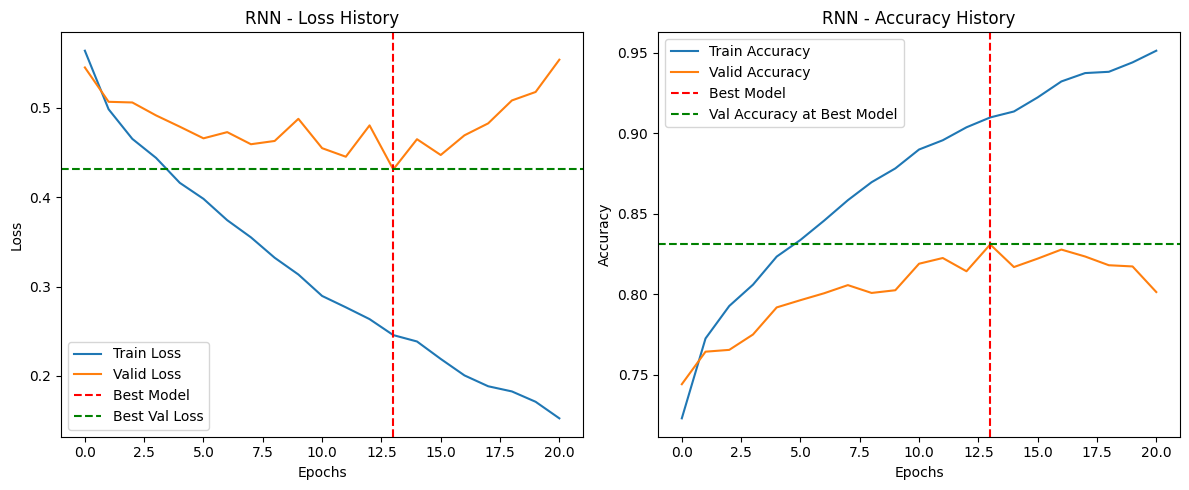

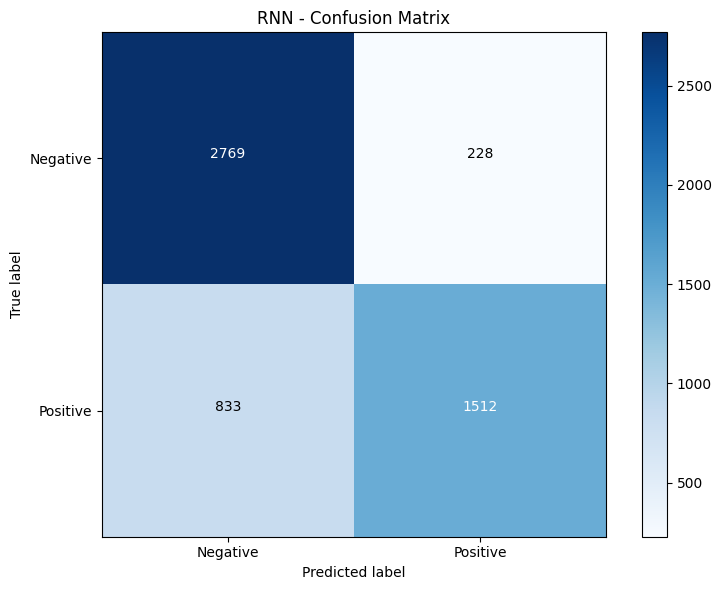

In [53]:
# Plotting hasil pelatihan
plot_training_history(history_rnn, "RNN")

# Plotting confusion matrix
y_pred_rnn = np.array(result_rnn['y_pred']).astype(int)
plot_confusion_matrix(y_test, y_pred_rnn, "RNN")

## 5. Menyimpan Model

In [54]:
# Menyimpan model
#torch.save(model_rnn.state_dict(), 'model_pytorch_rnn.pth')
#print("Model RNN disimpan sebagai 'model_pytorch_rnn.pth'")

# B. LSTM dengan PyTorch

## 1. Menyusun Model LSTM


In [ ]:
# Definisi Model LSTM
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=2)
        self.rnn2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2)
        self.rnn3 = nn.LSTM(hidden_dim, hidden_dim // 2, batch_first=True, num_layers=2)
            
        self.fc = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, text):
        embedded = self.embedding(text)
        
        output1, (hidden1, _) = self.rnn1(embedded)
        output2, (hidden2, _) = self.rnn2(output1)
        output3, (hidden3, _) = self.rnn3(output2)
        hidden = hidden3[-1, :, :]
            
        dropout_out = self.dropout(hidden)
        return torch.sigmoid(self.fc(dropout_out))

# Inisialisasi model LSTM    
model_lstm = LSTMModel(
        vocab_size=NUM_WORDS,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM
    ).to(DEVICE)

## 2. Melatih Model

In [56]:
# Inisialisasi loss function dan optimizer
criterion = nn.BCELoss()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)

# Melatih model LSTM
print("Melatih model LSTM...")
history_lstm = train_model(model_lstm, train_loader, criterion, optimizer_lstm, DEVICE, epochs=EPOCHS, model_name='lstm')

Melatih model LSTM...
Epoch: 1/25, Loss: 0.5287, Accuracy: 0.7458, Val Loss: 0.4557, Val Accuracy: 0.8001
Checkpoint: Model disimpan sebagai 'model_pytorch_lstm.pth' (validation loss terendah = 0.4557)
Epoch: 2/25, Loss: 0.4017, Accuracy: 0.8338, Val Loss: 0.3649, Val Accuracy: 0.8396
Checkpoint: Model disimpan sebagai 'model_pytorch_lstm.pth' (validation loss terendah = 0.3649)
Epoch: 3/25, Loss: 0.3225, Accuracy: 0.8717, Val Loss: 0.3177, Val Accuracy: 0.8662
Checkpoint: Model disimpan sebagai 'model_pytorch_lstm.pth' (validation loss terendah = 0.3177)
Epoch: 4/25, Loss: 0.2595, Accuracy: 0.9012, Val Loss: 0.3274, Val Accuracy: 0.8648
Epoch: 5/25, Loss: 0.2133, Accuracy: 0.9227, Val Loss: 0.3329, Val Accuracy: 0.8652
Epoch: 6/25, Loss: 0.1717, Accuracy: 0.9414, Val Loss: 0.3724, Val Accuracy: 0.8529
Epoch: 7/25, Loss: 0.1333, Accuracy: 0.9569, Val Loss: 0.3611, Val Accuracy: 0.8697
Epoch: 8/25, Loss: 0.1072, Accuracy: 0.9663, Val Loss: 0.4854, Val Accuracy: 0.8594
Epoch: 9/25, Loss:

## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [57]:
# Evaluasi model LSTM
result_lstm = evaluate_model(model_lstm, test_loader, criterion, DEVICE)
print("Evaluasi model LSTM selesai.")
print(f"Loss: {result_lstm['loss']:.4f}")
print(f"Accuracy: {result_lstm['accuracy']:.4f}")
print(f"Precision: {result_lstm['precision']:.4f}")
print(f"Recall: {result_lstm['recall']:.4f}")
print(f"F1 Score: {result_lstm['f1']:.4f}")
print(f"AUC: {result_lstm['auc']:.4f}")

Evaluasi model LSTM selesai.
Loss: 0.5771
Accuracy: 0.8521
Precision: 0.7843
Recall: 0.9147
F1 Score: 0.8445
AUC: 0.9326


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

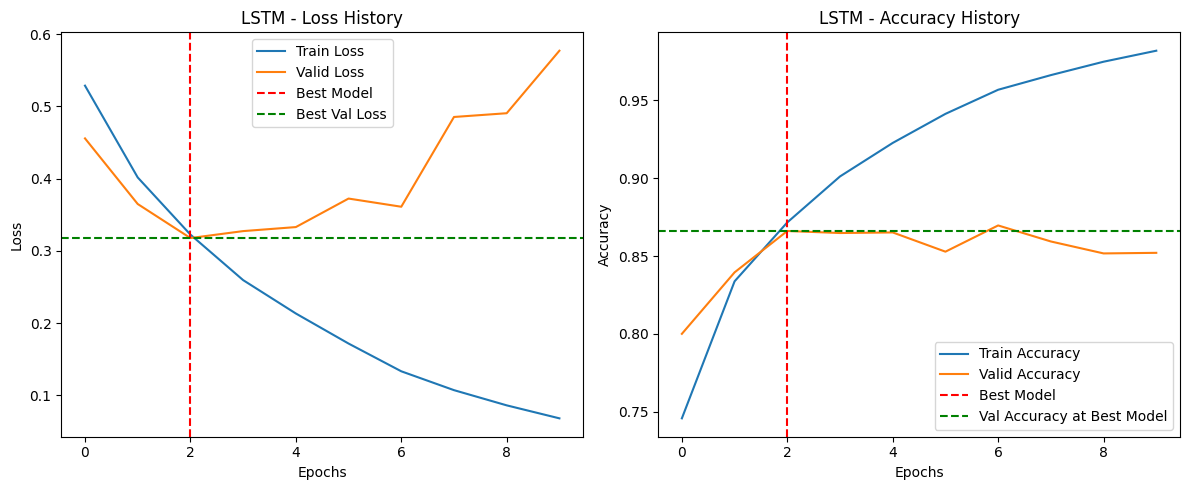

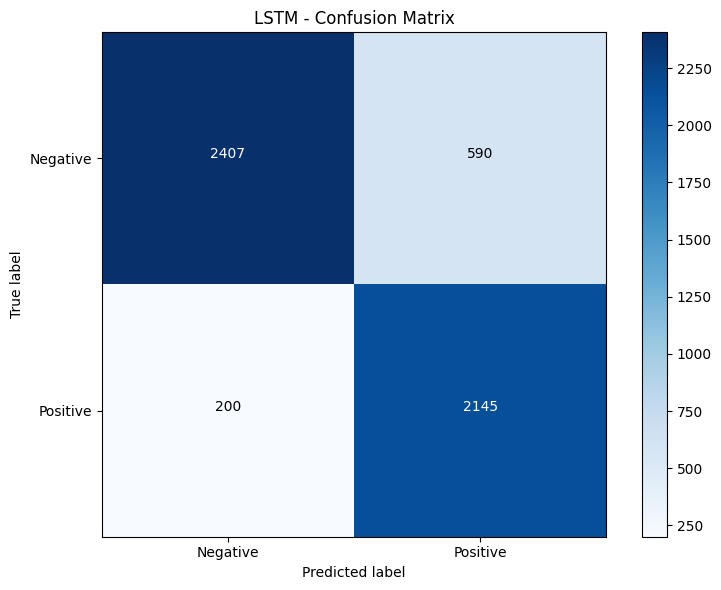

In [58]:
# Plotting hasil pelatihan
plot_training_history(history_lstm, "LSTM")

# Plotting confusion matrix
y_pred_lstm = np.array(result_lstm['y_pred']).astype(int)
plot_confusion_matrix(y_test, y_pred_lstm, "LSTM")

## 5. Menyimpan Model

In [59]:
# Menyimpan model
#torch.save(model_lstm.state_dict(), 'model_pytorch_lstm.pth')
#print("Model LSTM disimpan sebagai 'model_pytorch_lstm.pth'")

# C. GRU dengan PyTorch

## 1. Menyusun Model GRU


In [62]:
# Definisi Model GRU
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn1 = nn.GRU(embedding_dim, hidden_dim, batch_first=True, num_layers=2)
        self.rnn2 = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=2)
        self.rnn3 = nn.GRU(hidden_dim, hidden_dim // 2, batch_first=True, num_layers=2)
            
        self.fc = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, text):
        embedded = self.embedding(text)
        
        output1, hidden1 = self.rnn1(embedded)
        output2, hidden2 = self.rnn2(output1)
        output3, hidden3 = self.rnn3(output2)
        hidden = hidden3[-1, :, :]
            
        dropout_out = self.dropout(hidden)
        return torch.sigmoid(self.fc(dropout_out))
    
# Inisialisasi model GRU
model_gru = GRUModel(
        vocab_size=NUM_WORDS,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM
    ).to(DEVICE)

## 2. Melatih Model

In [63]:
# Inisialisasi loss function dan optimizer
criterion = nn.BCELoss()
optimizer_gru = optim.Adam(model_gru.parameters(), lr=LEARNING_RATE)

# Melatih model GRU
print("Melatih model gru...")
history_gru = train_model(model_gru, train_loader, criterion, optimizer_gru, DEVICE, epochs=EPOCHS, model_name='gru')

Melatih model gru...
Epoch: 1/25, Loss: 0.5136, Accuracy: 0.7574, Val Loss: 0.4356, Val Accuracy: 0.8074
Checkpoint: Model disimpan sebagai 'model_pytorch_gru.pth' (validation loss terendah = 0.4356)
Epoch: 2/25, Loss: 0.4099, Accuracy: 0.8284, Val Loss: 0.3925, Val Accuracy: 0.8347
Checkpoint: Model disimpan sebagai 'model_pytorch_gru.pth' (validation loss terendah = 0.3925)
Epoch: 3/25, Loss: 0.3407, Accuracy: 0.8650, Val Loss: 0.3588, Val Accuracy: 0.8482
Checkpoint: Model disimpan sebagai 'model_pytorch_gru.pth' (validation loss terendah = 0.3588)
Epoch: 4/25, Loss: 0.2889, Accuracy: 0.8891, Val Loss: 0.3642, Val Accuracy: 0.8502
Epoch: 5/25, Loss: 0.2456, Accuracy: 0.9106, Val Loss: 0.3559, Val Accuracy: 0.8581
Checkpoint: Model disimpan sebagai 'model_pytorch_gru.pth' (validation loss terendah = 0.3559)
Epoch: 6/25, Loss: 0.2077, Accuracy: 0.9284, Val Loss: 0.4519, Val Accuracy: 0.8293
Epoch: 7/25, Loss: 0.1752, Accuracy: 0.9408, Val Loss: 0.3825, Val Accuracy: 0.8589
Epoch: 8/25

## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [64]:
# Evaluasi model GRU
print("Evaluasi model GRU...")
result_gru = evaluate_model(model_gru, test_loader, criterion, DEVICE)
print("Evaluasi model GRU selesai.")
print(f"Loss: {result_gru['loss']:.4f}")
print(f"Accuracy: {result_gru['accuracy']:.4f}")
print(f"Precision: {result_gru['precision']:.4f}")
print(f"Recall: {result_gru['recall']:.4f}")
print(f"F1 Score: {result_gru['f1']:.4f}")
print(f"AUC: {result_gru['auc']:.4f}")


Evaluasi model GRU...
Evaluasi model GRU selesai.
Loss: 0.5353
Accuracy: 0.8559
Precision: 0.7995
Recall: 0.8964
F1 Score: 0.8452
AUC: 0.9306


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

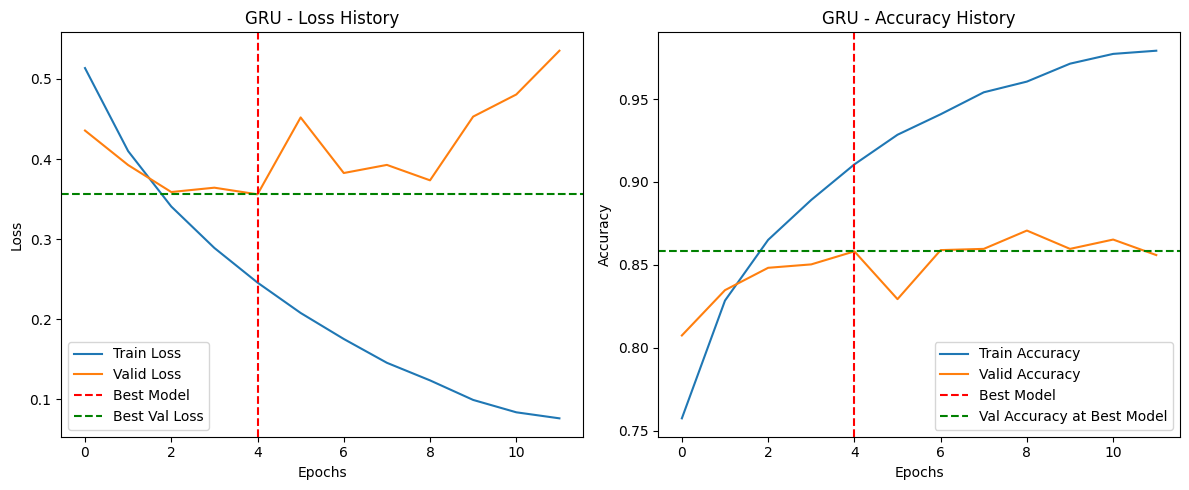

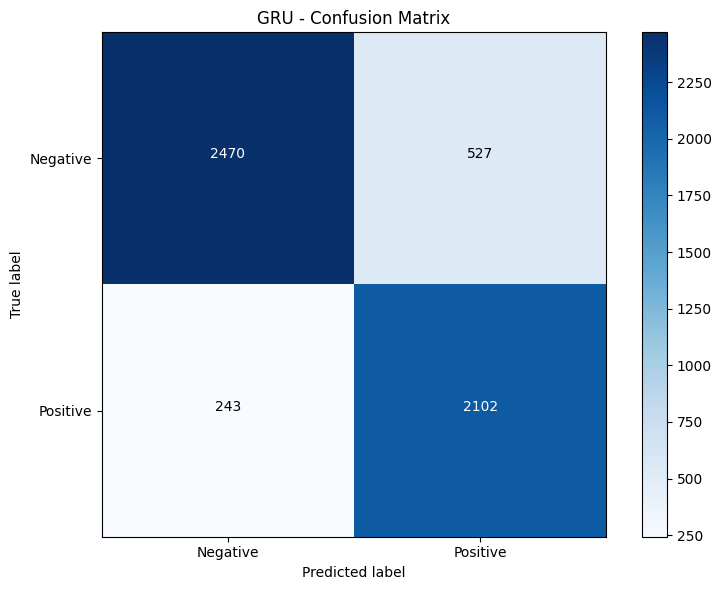

In [65]:
# Plotting hasil pelatihan
plot_training_history(history_gru, "GRU")

# Plotting confusion matrix
y_pred_gru = np.array(result_gru['y_pred']).astype(int)
plot_confusion_matrix(y_test, y_pred_gru, "GRU")

## 5. Menyimpan Model

In [66]:
# Menyimpan model
#torch.save(model_gru.state_dict(), 'model_pytorch_gru.pth')
#print("Model GRU disimpan sebagai 'model_pytorch_gru.pth'")

# Perbandingan antara model

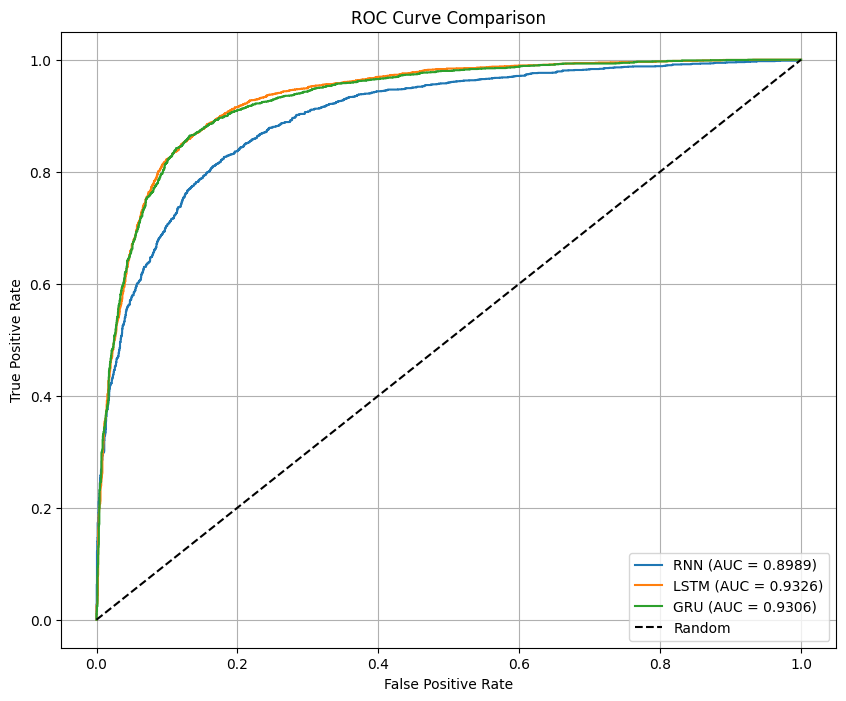

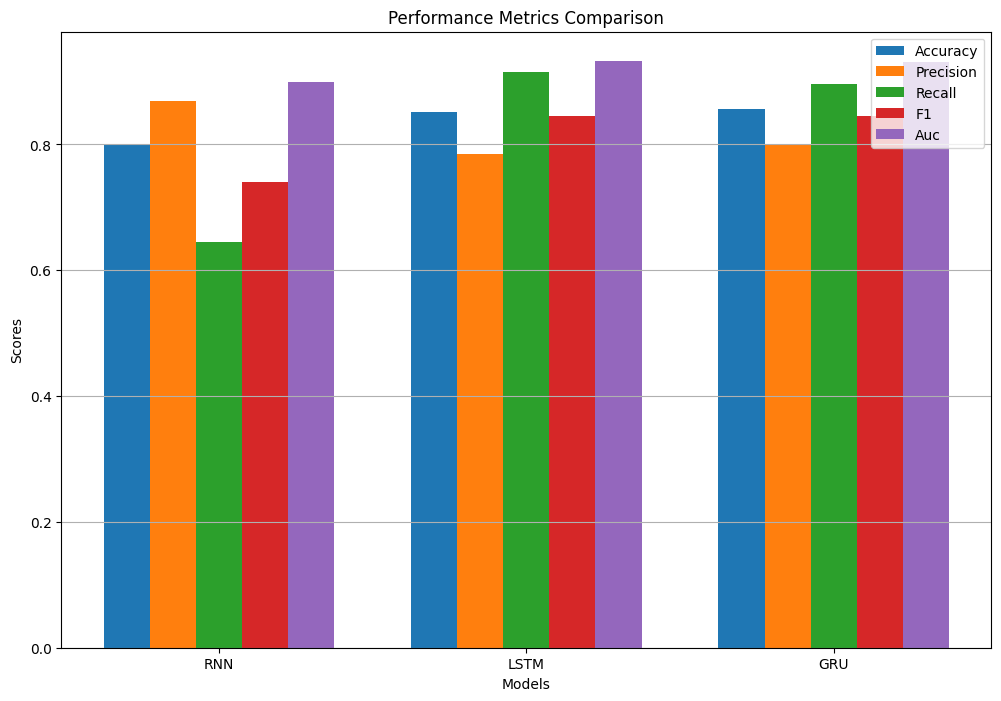

In [67]:
# Menghitung perbandingan untuk semua model
results_dict = {
    'RNN': result_rnn,
    'LSTM': result_lstm,
    'GRU': result_gru
}

# Plotting ROC curve
plot_roc_curve(results_dict)
# Plotting perbandingan metrik
plot_metrics_comparison(results_dict)